
# Turbofan RUL — Exploratory Data Analysis (NASA CMAPSS FD001)

This notebook performs data exploration for the CMAPSS FD001 subset:
- Dataset overview (units, cycles)
- Cycle-to-failure statistics
- Sensor behavior over cycles
- Correlation analysis vs `cycle`
- Save key plots to `assets/`


In [2]:

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Resolve project root even if this runs inside notebooks/
ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA = ROOT / "data" / "raw"
ASSETS = ROOT / "assets"
ASSETS.mkdir(exist_ok=True)

print("ROOT   :", ROOT)
print("DATA   :", DATA, "| exists:", DATA.exists())
print("ASSETS :", ASSETS)


ROOT   : /Users/isawgod/Documents/project/turbofan-rul-prediction
DATA   : /Users/isawgod/Documents/project/turbofan-rul-prediction/data/raw | exists: True
ASSETS : /Users/isawgod/Documents/project/turbofan-rul-prediction/assets


In [3]:

# Robust reader for FD001
def read_fd(fd="FD001"):
    tr = pd.read_csv(DATA / f"train_{fd}.txt", sep=r"\s+", header=None, engine="python")
    te = pd.read_csv(DATA / f"test_{fd}.txt",  sep=r"\s+", header=None, engine="python")
    rl = pd.read_csv(DATA / f"RUL_{fd}.txt",   sep=r"\s+", header=None, engine="python")
    tr, te, rl = tr.dropna(axis=1, how="all"), te.dropna(axis=1, how="all"), rl.dropna(axis=1, how="all")
    cols = (["unit","cycle"] + [f"setting_{i}" for i in range(1,4)] + [f"s{i:02d}" for i in range(1,22)])
    tr.columns = cols[:tr.shape[1]]
    te.columns = cols[:te.shape[1]]
    rl.columns = ["RUL"]
    return tr, te, rl

train, test, rul = read_fd("FD001")
display(train.head())
print("Shapes:", train.shape, test.shape, rul.shape)
print("Units in train:", train['unit'].nunique(), "| Units in test:", test['unit'].nunique())


,unit,cycle,setting_1,setting_2,setting_3,s01,s02,s03,s04,s05,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Shapes: (20631, 26) (13096, 26) (100, 1)
Units in train: 100 | Units in test: 100


## Cycles-to-failure statistics

count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: cycle, dtype: float64

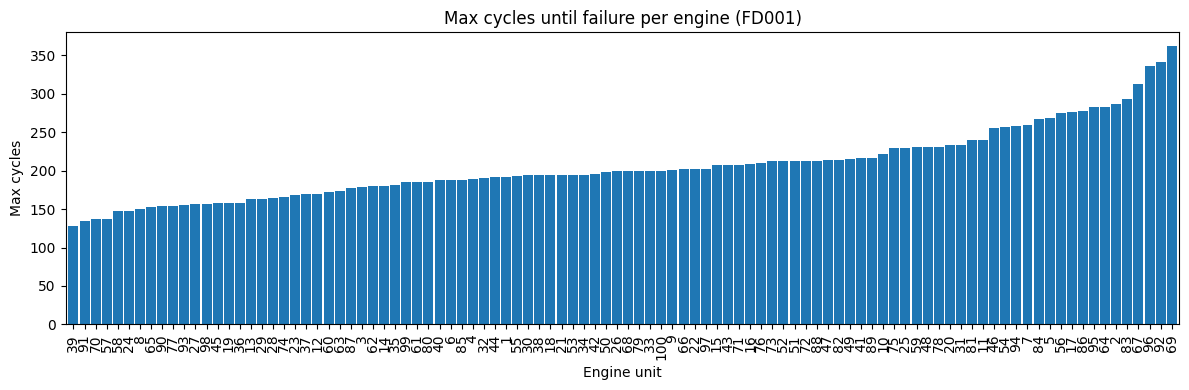

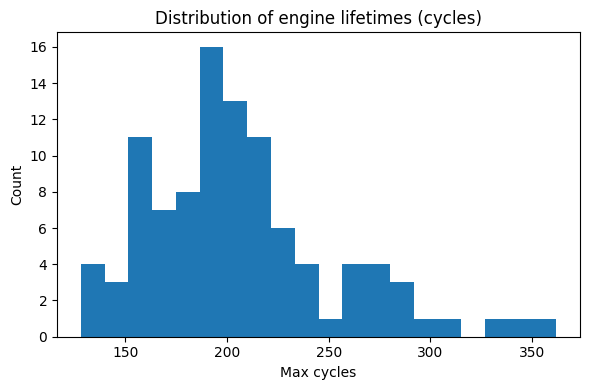

In [4]:

cycles_per_unit = train.groupby('unit')['cycle'].max().sort_values()
display(cycles_per_unit.describe())

# Bar plot
plt.figure(figsize=(12,4))
cycles_per_unit.plot(kind='bar', width=0.9)
plt.title("Max cycles until failure per engine (FD001)")
plt.xlabel("Engine unit"); plt.ylabel("Max cycles")
plt.tight_layout()
plt.savefig(ASSETS / "cycles_per_unit_bar.png", dpi=150, bbox_inches="tight")
plt.show()

# Histogram
plt.figure(figsize=(6,4))
plt.hist(cycles_per_unit.values, bins=20)
plt.title("Distribution of engine lifetimes (cycles)")
plt.xlabel("Max cycles"); plt.ylabel("Count")
plt.tight_layout()
plt.savefig(ASSETS / "cycles_hist.png", dpi=150, bbox_inches="tight")
plt.show()


## Sensor behavior over cycles (sample engines)

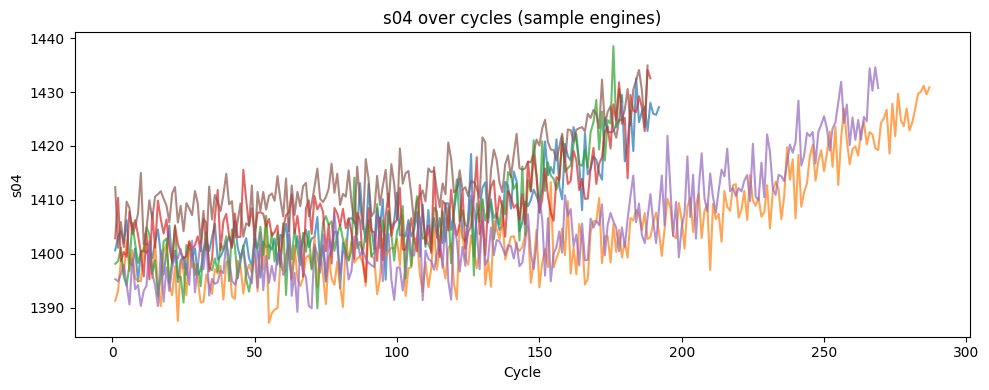

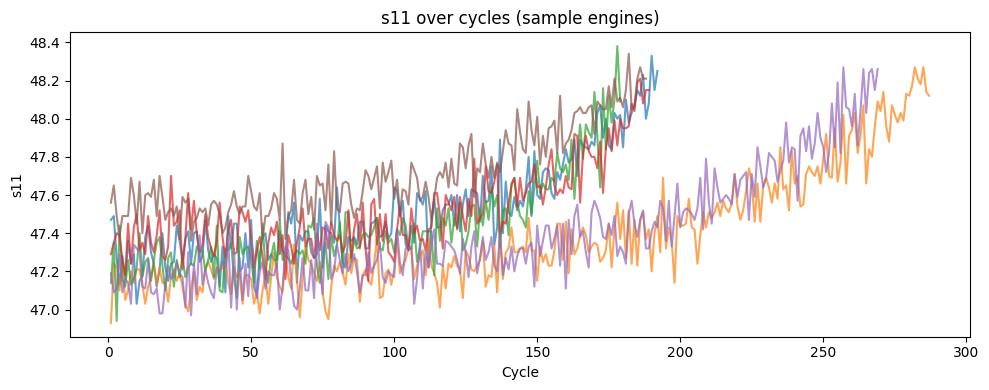

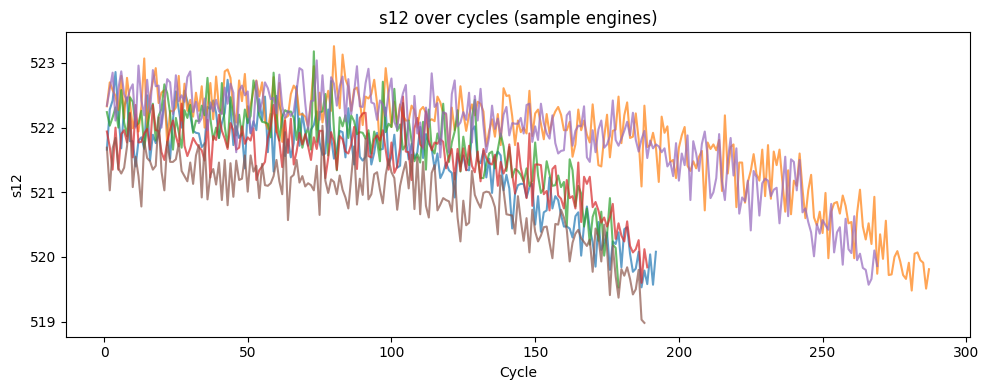

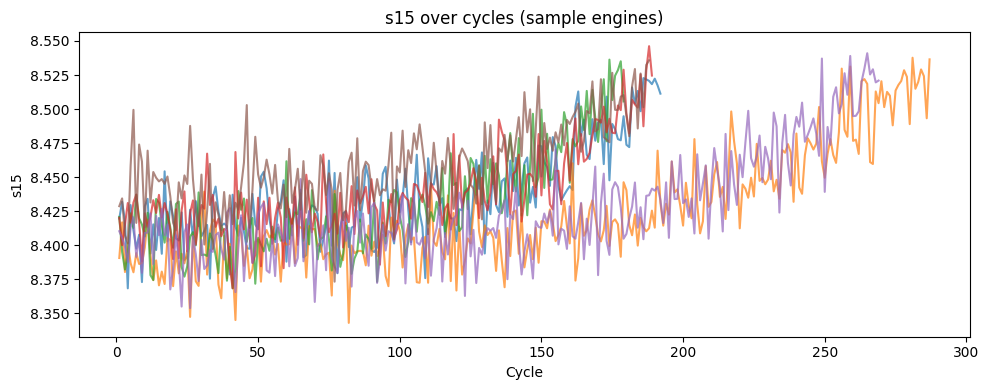

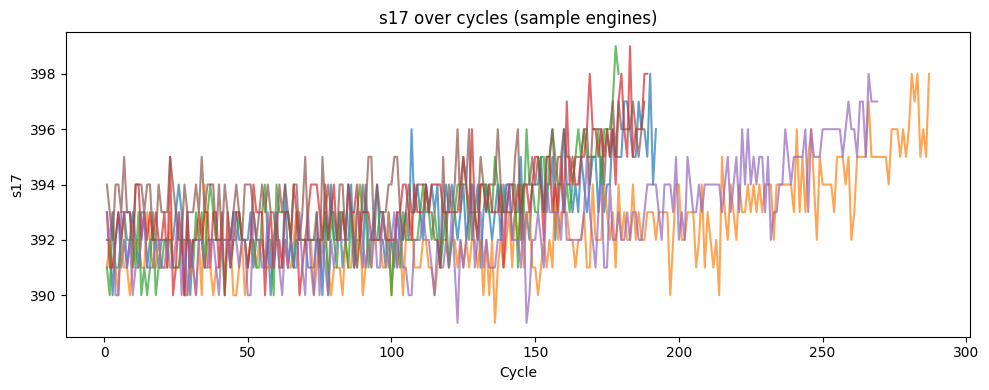

In [5]:

key_sensors = ["s04","s11","s12","s15","s17"]
sample_units = train['unit'].unique()[:6]

for sensor in key_sensors:
    plt.figure(figsize=(10,4))
    for u in sample_units:
        df_u = train[train['unit']==u]
        plt.plot(df_u['cycle'], df_u[sensor], alpha=0.7, label=f"unit {u}")
    plt.title(f"{sensor} over cycles (sample engines)")
    plt.xlabel("Cycle"); plt.ylabel(sensor)
    plt.tight_layout()
    plt.savefig(ASSETS / f"{sensor}_sample_units.png", dpi=150, bbox_inches="tight")
    plt.show()


## Correlation of sensors with cycle

s12         -0.611354
s07         -0.595914
s21         -0.585923
s20         -0.583597
setting_1   -0.004527
setting_2    0.016132
s06          0.105980
s14          0.370324
s09          0.443999
s08          0.475977
Name: cycle, dtype: float64

s15          0.588676
s04          0.624577
s11          0.634385
setting_3         NaN
s01               NaN
s05               NaN
s10               NaN
s16               NaN
s18               NaN
s19               NaN
Name: cycle, dtype: float64

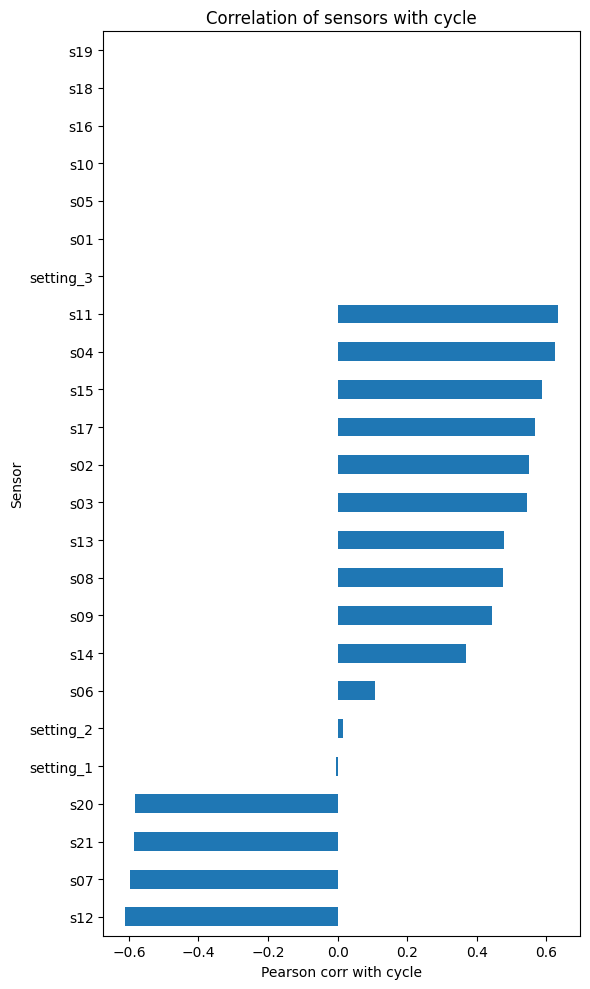

In [6]:

sensor_cols = [c for c in train.columns if c.startswith("s")]
corr = train[["cycle"] + sensor_cols].corr()["cycle"].drop("cycle").sort_values()
display(corr.head(10))
display(corr.tail(10))

plt.figure(figsize=(6,10))
corr.sort_values().plot(kind="barh")
plt.title("Correlation of sensors with cycle")
plt.xlabel("Pearson corr with cycle"); plt.ylabel("Sensor")
plt.tight_layout()
plt.savefig(ASSETS / "corr_cycle_all_sensors.png", dpi=150, bbox_inches="tight")
plt.show()


## Rolling means (unit-wise) to smooth noisy sensors

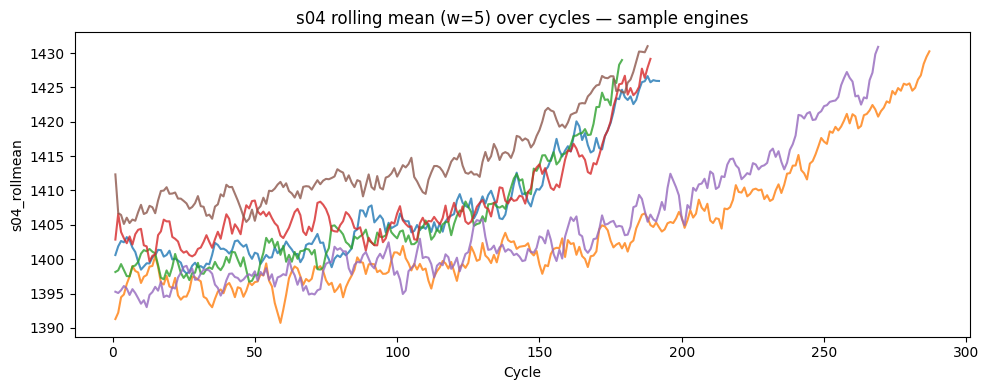

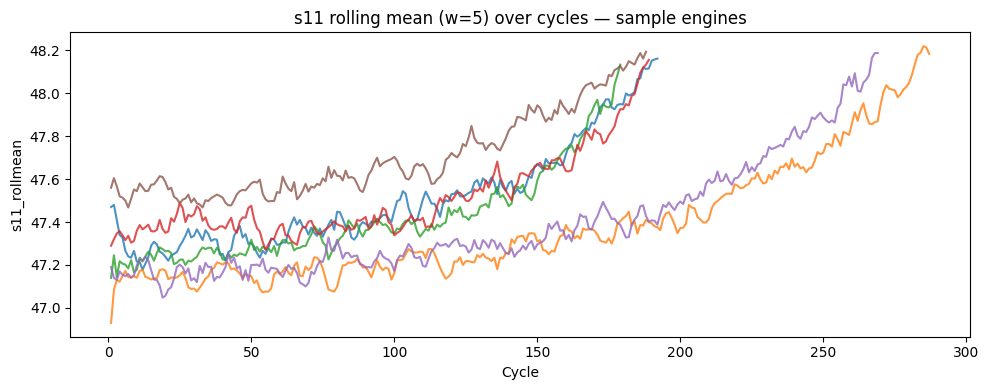

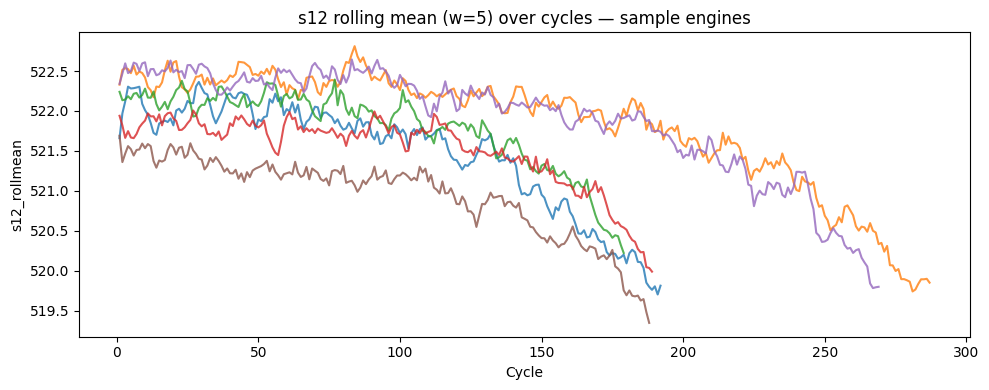

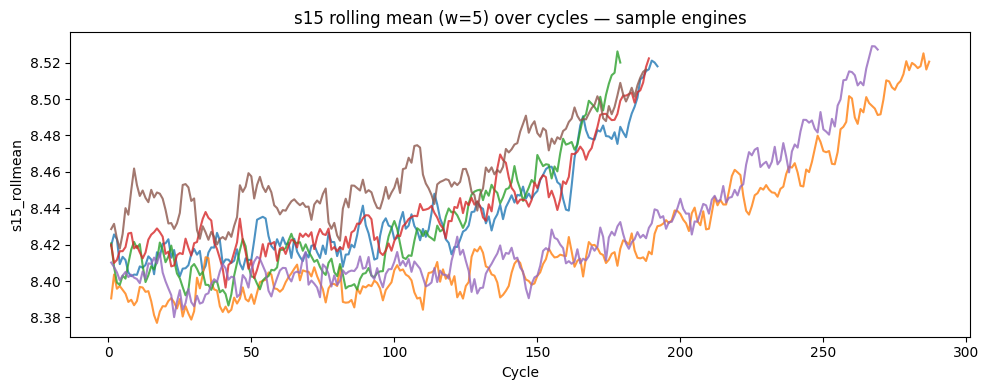

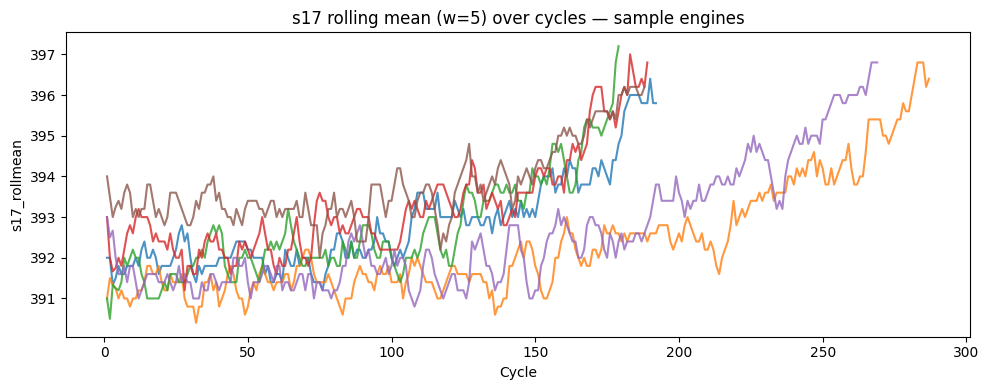

In [7]:

def add_rolling_means(df, sensors, window=5):
    df = df.copy().sort_values(['unit','cycle'])
    for s in sensors:
        df[f"{s}_rollmean"] = df.groupby('unit')[s].transform(lambda x: x.rolling(window, min_periods=1).mean())
    return df

train_roll = add_rolling_means(train, key_sensors, window=5)

for s in key_sensors:
    plt.figure(figsize=(10,4))
    for u in sample_units:
        df_u = train_roll[train_roll['unit']==u]
        plt.plot(df_u['cycle'], df_u[f"{s}_rollmean"], alpha=0.8, label=f"unit {u}")
    plt.title(f"{s} rolling mean (w=5) over cycles — sample engines")
    plt.xlabel("Cycle"); plt.ylabel(f"{s}_rollmean")
    plt.tight_layout()
    plt.savefig(ASSETS / f"{s}_rolling_mean.png", dpi=150, bbox_inches="tight")
    plt.show()


## Export quick samples (optional)

In [8]:

SAMPLES = ROOT / "samples"
SAMPLES.mkdir(exist_ok=True)

# RAW sample (first 50 rows of unit 1)
raw_cols = ["unit","cycle"] + [f"s{i:02d}" for i in range(1,22)]
raw_sample = train.loc[train["unit"]==1, raw_cols].head(50).copy()
raw_sample.to_csv(SAMPLES / "raw_sample.csv", index=False)

print("Saved samples to:", SAMPLES)
print("Saved plots to  :", ASSETS)


Saved samples to: /Users/isawgod/Documents/project/turbofan-rul-prediction/samples
Saved plots to  : /Users/isawgod/Documents/project/turbofan-rul-prediction/assets
